## Analysis: Titanic's passengers survival

- **Dataset**: https://www.kaggle.com/datasets/yasserh/titanic-dataset/data


Column definitions:
- `PassengerId`: Passenger Id.
- `Survived`: Survival 
  - **0** = No 
  - **1** = Yes.
- `Pclass`: Ticket class
  - **1** = First class
  - **2** = Second class
  - **3** = Third class.
- `Name`: Passenger's name.
- `Sex`: Passenger's genre.
- `Age`: Passenger's age in years.
- `SibSp`: Number of sibligs / spouse aboard.
- `Parch`: Number of parents / children aboard.
- `Ticket`: Ticket number.
- `Fare`: Passenger's fare.
- `Cabin`: Cabin number.
- `Embarked`:  Port of embarkation
  - **C** = Cherbourg
  - **Q** = Queenstown
  - **S** = Southampton

## Libraries

In [12]:
%run 0.0-data_projects-setup.ipynb
%run pandas-missing-extension.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
import janitor

# Missin Values Analysis
import missingno as msno

## Downdload and load data

Download dataset from kaggle:

In [14]:
from_kaggle("yasserh/titanic-dataset", "Titanic-Dataset.csv")

Dataset Titanic-Dataset.csv is already downloaded


Load and preview data:

In [15]:
df = pd.read_csv(path.data_raw_dir("Titanic-Dataset.csv"))
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


## Cleaning data

### Standarizing column names

In [17]:
df = df.clean_names(case_type="snake")
df.columns

Index(['unnamed_0', 'passenger_id', 'survived', 'pclass', 'name', 'sex', 'age',
       'sib_sp', 'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Drop unnecesary columns

Columns `passenger_id` and `unnamed_0` contain consecutive id values, and they don't add valuable information to the analysis, so we can drop them.

In [18]:
df = df.drop(columns=["passenger_id", "unnamed_0"])

### Handling missing values

In [19]:
df.missing.missing_variable_summary().sort_values(by="pct_missing", ascending=False)

,variable,n_missing,n_cases,pct_missing
9,cabin,687,891,77.104377
4,age,177,891,19.865320
10,embarked,2,891,0.224467
2,name,0,891,0.000000
1,pclass,0,891,0.000000
0,survived,0,891,0.000000
3,sex,0,891,0.000000
6,parch,0,891,0.000000
5,sib_sp,0,891,0.000000
8,fare,0,891,0.000000


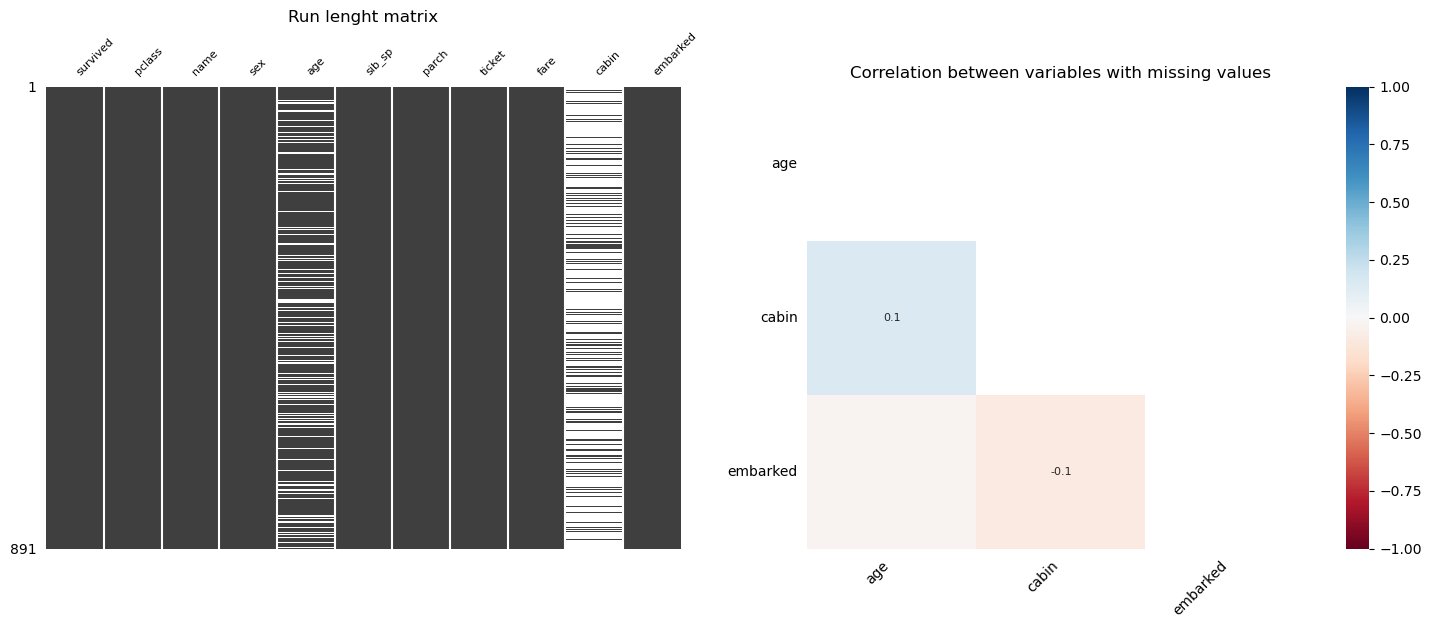

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))

msno.matrix(df=df, figsize=(8, 6), fontsize=8, ax=axes[0], sparkline=False)
axes[0].set_title("Run lenght matrix")

msno.heatmap(df, figsize=(8, 4), fontsize=10, ax=axes[1])
axes[1].set_title("Correlation between variables with missing values");

**Observations**
- According to the graphs above, there don't appear to be any patterns or corelations in the missing values.
- `embarked`'s null values represent only $0.22\%$ of data, so we can delete those rows or impute them with the most repeted value (mode).
- `age` column has 177 null values, deleting almost 20% of the observations could be counterproductive for this analysis. So, in this case, we can impute the median value by groups (grouped by `pclass`).
- The `cabin` column contains more null values than actual data. Therefore, it's more convinient exclude this variable from the análisis. However, we can create a new column called `has_cabin` to indicate whether a passenger has cabin information or not.


#### Imputing missing values

In [71]:
# Imputed embarked with the top.
top_embarked = df["embarked"].describe().top
df["embarked"] = df["embarked"].fillna(top_embarked)

# Creating new column, which indicates wheter a passenger has cabin information
df["has_cabin"] = df["cabin"].notnull().astype(int)
df.drop(columns=["cabin"], inplace=True)

`age` Imputation is performed by grouping passengers according to their `pclass`.

In [57]:
df["age"] = df.groupby(['pclass'])["age"].transform(lambda x: x.fillna(x.mean()))

In [72]:
df.isnull().sum().sum()

np.int64(0)